In [1]:
# pip install -U andi-datasets
#$import andi_datasets

## models

In [2]:
from andi_datasets.datasets_theory import datasets_theory
AD = datasets_theory()
model_names=AD.avail_models_name
print(model_names)

c:\Users\ccx55\Anaconda3\envs\DLCC\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['attm', 'ctrw', 'fbm', 'lw', 'sbm']


## simulation of trajectories

In [3]:
dim=2 # dimensionality of the problem
T=100 # number of timesteps
N=150 # number of trajectories per model and anomalous diffusion exponent
models=0 #index of the model 
alpha=1. # anomalous diffusion exponent
dataset = AD.create_dataset(T = T + 1, N_models = N, exponents = alpha, models = models, dimension=dim, save_trajectories = False)

print("Size:", dataset.shape) 

Size: (150, 204)


## training/test dataset

In [4]:
import numpy as np
dim=2 
T=100 
N=4000
models=[0,1]
alpha=(np.random.rand(N)+.2)/1.2
dataset_attm_ctrw = AD.create_dataset(T = T + 1, N_models = 1, exponents = alpha, models = models, dimension=dim, save_trajectories = False)

In [5]:
models=[2,4]
alpha=(np.random.rand(N)*1.8)+0.2
dataset_fbm_sbm = AD.create_dataset(T = T + 1, N_models = 1, exponents = alpha, models = models, dimension=dim, save_trajectories = False)
dataset=np.append(dataset_attm_ctrw , dataset_fbm_sbm, axis=0)


In [6]:
models=3
alpha=(np.random.rand(N)+1.)
dataset_lw = AD.create_dataset(T = T + 1, N_models = 1, exponents = alpha, models = models, dimension=dim, save_trajectories = False)
dataset=np.append(dataset , dataset_lw, axis=0)

In [7]:
dataset.shape

(20000, 204)

## adding localization noise

In [8]:
dataset= AD.create_noisy_diffusion_dataset(dataset, diffusion_coefficients=1., T = T + 1, dimension=2)
dataset = AD.create_noisy_localization_dataset(dataset, T = T + 1, dimension=2, sigma=0.1)
dataset= AD.create_noisy_diffusion_dataset(dataset,  T = T + 1, dimension=2)

## visualization

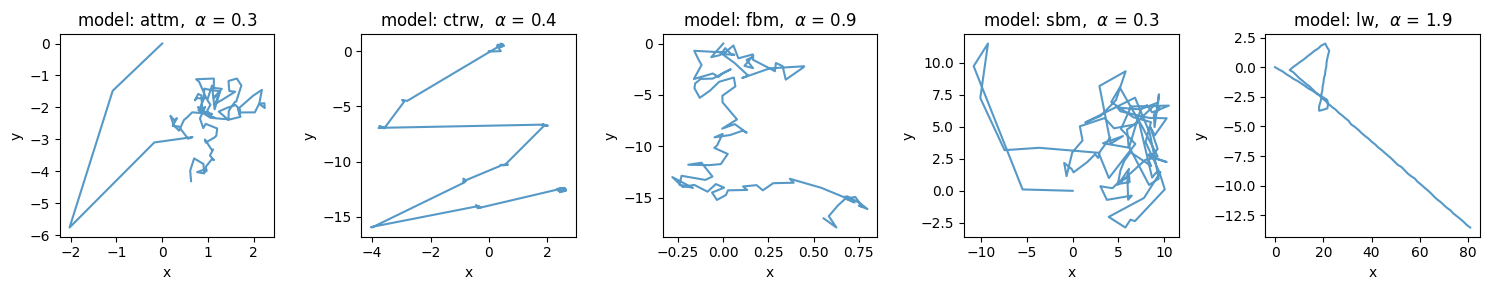

In [9]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, len(model_names), figsize=((15, 3)), tight_layout = True)
labels = dataset[:,:2]
trajs = dataset[:,2:]
trajs = trajs.reshape(dataset.shape[0],T+1,dim,order='F')

for i in range(len(model_names)):
    ind=np.random.choice(np.arange(0+N*i, N*(i+1)))
    axs[i].plot(trajs[ind,:, 0], trajs[ind,:, 1], alpha = 0.75)
    axs[i].set_title(r'model: {:s},  $\alpha$ = {:.1f}'.format(model_names[int(labels[ind,0])], labels[ind,1])  )

    plt.setp(axs[i], xlabel = 'x', ylabel = 'y')




## utils

In [10]:
def standardize(disp):    
    disp -= disp.mean(axis=1, keepdims=True)
    disp /=  disp.std(axis=1, keepdims=True)
    return disp

def digits_to_one_hot(digits, nclasses): 
    from numpy import zeros
    one_hot_labels = zeros((digits.shape[0], nclasses))
    for idx, digit in enumerate(digits): 
        one_hot_labels[idx, digit] = 1
    return one_hot_labels
    
def one_hot_to_digit(one_hot_labels): 
    from numpy import argmax
    return argmax(one_hot_labels , axis=-1)

def accuracy(predictions, groundtruths):
# Both predictions and ground truths are given in one-hot format
    predictions = one_hot_to_digit(predictions) 
    groundtruths = one_hot_to_digit(groundtruths)
    correct = sum(predictions == groundtruths)
    total = predictions.shape[0]
    return correct / total

## data preparation

In [11]:

from torch.utils.data import random_split, TensorDataset, DataLoader
import torch
window_size=2
ratio = 0.8
np.random.shuffle(dataset)
labels = dataset[:,:2]
trajs = dataset[:,2:]
trajs = trajs.reshape(dataset.shape[0],T+1,dim,order='F')
displ = standardize(np.diff(trajs,axis=1))
batch_size=64

# NN inputs: trajectories
X_train=displ.reshape(displ.shape[0],int(T/window_size),window_size*dim)
y_train=digits_to_one_hot(labels[:,0].astype(int), 5)


# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

# Splitting the dataset into training and validation
train_dataset = TensorDataset(X_train, y_train)
train_dataset, test_dataset = random_split(train_dataset, [ratio, 1-ratio])
train_dataset, val_dataset = random_split(train_dataset, [ratio, 1-ratio])

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


## Simple RNN

In [12]:
import sys
sys.path.append('./deeplay') #if deeplay is not pip-installed
import deeplay as dl
import torch

n_timesteps=int(T/window_size)
n_features=dim*window_size
n_outputs=5

rnn = dl.RNN(n_features,hidden_features=[100],out_features=n_outputs,dropout=0.2,rnn_type="RNN")
model = dl.Classifier(rnn, loss=torch.nn.CrossEntropyLoss(),optimizer=dl.Adam(lr=0.001))
model=model.create()
print(model)


Classifier(
  (loss): CrossEntropyLoss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): RNN(
    (blocks): LayerList(
      (0): RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): RNN(4, 100, batch_first=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (1): MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): Linear(in_features=100, out_features=5, bias=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Dropout(p=0, inplace=False)
          )
        )
      )
    )
    (rnn): RecurrentNeuralNetwork(
      (blocks): LayerList(
        (0): LayerActivationNormal

In [13]:
def train_and_predict(model,epochs=30):
    trainer = dl.Trainer(max_epochs=epochs,accelerator="auto")
    trainer.fit(model, train_loader,val_dataloaders=val_loader)

    test_output = trainer.predict(model, test_loader)

    y_test = []
    for batch in test_loader:
        y_test.append(batch[1])
    
    y_test = torch.cat(y_test, dim=0)
    test_output = torch.cat(test_output, dim=0)
    
    return y_test,test_output
    
y_test,predicted_y=train_and_predict(model)
computed_accuracy = accuracy(predicted_y, y_test)
print ("Accuracy:" , computed_accuracy)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\ccx55\Anaconda3\envs\DLCC\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_f

c:\Users\ccx55\Anaconda3\envs\DLCC\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\ccx55\Anaconda3\envs\DLCC\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 29: 100%|██████████| 201/201 [00:01<00:00, 145.66it/s, v_num=60, train_loss_step=0.214, val_loss_step=0.802, val_loss_epoch=0.798, train_loss_epoch=0.782]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 201/201 [00:01<00:00, 145.24it/s, v_num=60, train_loss_step=0.214, val_loss_step=0.802, val_loss_epoch=0.798, train_loss_epoch=0.782]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\ccx55\Anaconda3\envs\DLCC\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.



Predicting DataLoader 0: 100%|██████████| 63/63 [00:00<00:00, 605.76it/s]
Accuracy: tensor(0.6512)


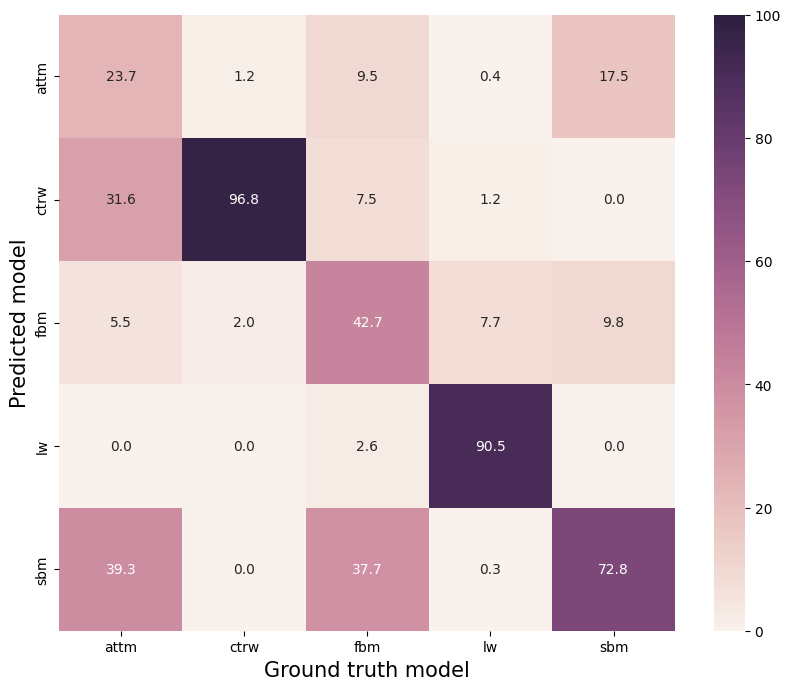

In [14]:
from seaborn import heatmap , cubehelix_palette
from numpy import zeros

def confusion_matrix(predicted_y,y_test):
    # Compute the confusion matrix
    confusion_matrix = zeros((5, 5))
    predicted = one_hot_to_digit(predicted_y)
    groundtruth = one_hot_to_digit(y_test)
    for groundtruth_m , predicted_m in zip(groundtruth , predicted):
        confusion_matrix[ predicted_m, groundtruth_m ] += 1
    confusion_matrix=100.*confusion_matrix/confusion_matrix.sum(axis=0,keepdims=1)
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8)) 
    heatmap(confusion_matrix, annot=True, fmt=".1f", square=True, cmap=cubehelix_palette(light=0.95, as_cmap=True), vmax =100)
    plt.ylabel("Predicted model", fontsize=15)
    plt.xlabel("Ground truth model", fontsize=15) 
    locs, NA = plt.xticks() 
    plt.xticks(ticks=locs, labels=model_names)
    locs, NA = plt.yticks() 
    plt.yticks(ticks=locs, labels=model_names)

    plt.show()

confusion_matrix(predicted_y,y_test)

## GRU

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | RNN              | 32.3 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
32.3 K    Trainable params
0         Non-trainable params
32.3 K    Total params
0.129     Total estimated model params size (MB)


Classifier(
  (loss): CrossEntropyLoss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): RNN(
    (blocks): LayerList(
      (0): RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): GRU(4, 100, batch_first=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (1): MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): Linear(in_features=100, out_features=5, bias=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Dropout(p=0, inplace=False)
          )
        )
      )
    )
    (rnn): RecurrentNeuralNetwork(
      (blocks): LayerList(
        (0): LayerActivationNormal

c:\Users\ccx55\Anaconda3\envs\DLCC\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\ccx55\Anaconda3\envs\DLCC\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 29: 100%|██████████| 201/201 [00:01<00:00, 168.43it/s, v_num=61, train_loss_step=0.457, val_loss_step=0.806, val_loss_epoch=0.805, train_loss_epoch=0.744]   

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 201/201 [00:01<00:00, 167.58it/s, v_num=61, train_loss_step=0.457, val_loss_step=0.806, val_loss_epoch=0.805, train_loss_epoch=0.744]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\ccx55\Anaconda3\envs\DLCC\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.



Predicting DataLoader 0: 100%|██████████| 63/63 [00:00<00:00, 563.24it/s]
Accuracy: tensor(0.6449)


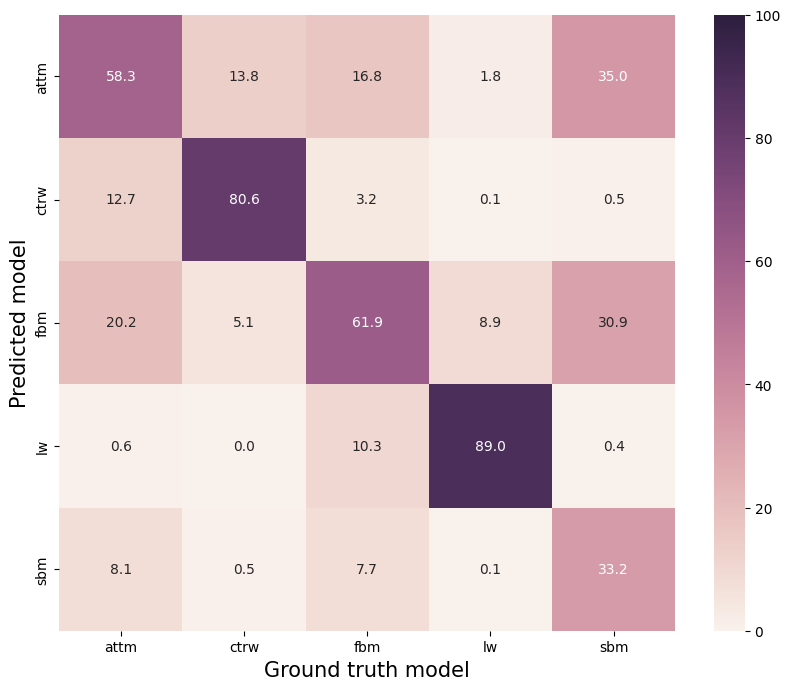

In [15]:
rnn.blocks[0].layer.configure(torch.nn.GRU)
model = dl.Classifier(rnn, loss=torch.nn.CrossEntropyLoss(),optimizer=dl.Adam(lr=0.01))
model=model.create()
print(model)

y_test,predicted_y=train_and_predict(model)
computed_accuracy = accuracy(predicted_y, y_test)
print ("Accuracy:" , computed_accuracy)
confusion_matrix(predicted_y,y_test)

## LSTM

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | RNN              | 11.5 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
11.5 K    Trainable params
0         Non-trainable params
11.5 K    Total params
0.046     Total estimated model params size (MB)


Classifier(
  (loss): CrossEntropyLoss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): RNN(
    (blocks): LayerList(
      (0): RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): LSTM(4, 50, batch_first=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (1): MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): Linear(in_features=50, out_features=5, bias=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Dropout(p=0, inplace=False)
          )
        )
      )
    )
    (rnn): RecurrentNeuralNetwork(
      (blocks): LayerList(
        (0): LayerActivationNormali

c:\Users\ccx55\Anaconda3\envs\DLCC\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\ccx55\Anaconda3\envs\DLCC\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 29: 100%|██████████| 201/201 [00:04<00:00, 43.89it/s, v_num=63, train_loss_step=0.00654, val_loss_step=0.668, val_loss_epoch=0.499, train_loss_epoch=0.312]  

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 201/201 [00:04<00:00, 43.64it/s, v_num=63, train_loss_step=0.00654, val_loss_step=0.668, val_loss_epoch=0.499, train_loss_epoch=0.312]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


c:\Users\ccx55\Anaconda3\envs\DLCC\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 63/63 [00:00<00:00, 155.61it/s]
Accuracy: tensor(0.8067)


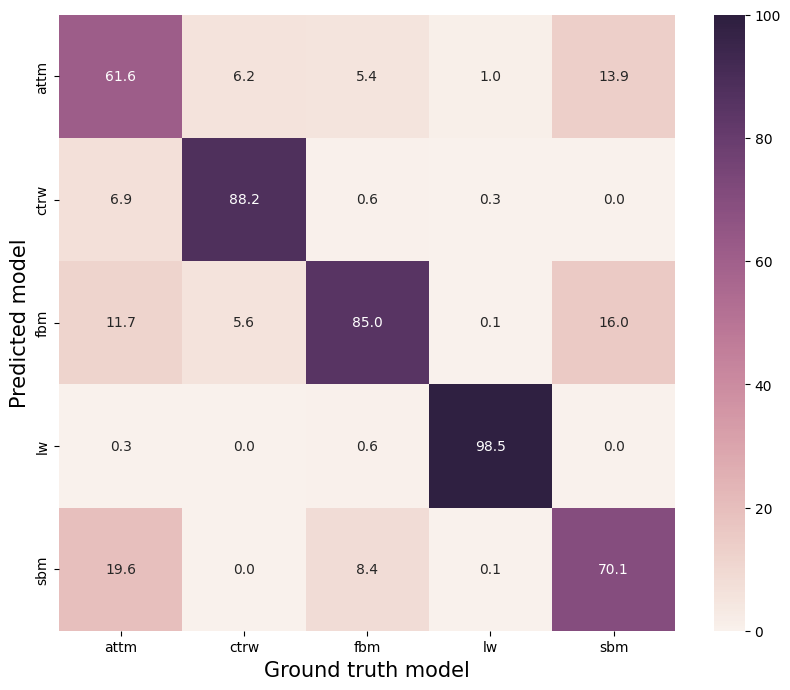

In [17]:
rnn.blocks[0].layer.configure(torch.nn.LSTM)
rnn.blocks[0].layer.configure(hidden_size=50) #to bring the total parameter count more in-line with a simple RNN
rnn.blocks[1].layer.configure(in_features=50)
model = dl.Classifier(rnn, loss=torch.nn.CrossEntropyLoss(),optimizer=dl.Adam(lr=0.01))
model=model.create()
print(model)

y_test,predicted_y=train_and_predict(model)
computed_accuracy = accuracy(predicted_y, y_test)
print ("Accuracy:" , computed_accuracy)
confusion_matrix(predicted_y,y_test)

## Bidirectional LSTM

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | RNN              | 22.7 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
22.7 K    Trainable params
0         Non-trainable params
22.7 K    Total params
0.091     Total estimated model params size (MB)


Classifier(
  (loss): CrossEntropyLoss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): RNN(
    (blocks): LayerList(
      (0): RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): LSTM(4, 50, batch_first=True, bidirectional=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (1): MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): Linear(in_features=50, out_features=5, bias=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Dropout(p=0, inplace=False)
          )
        )
      )
    )
    (rnn): RecurrentNeuralNetwork(
      (blocks): LayerList(
        (0): La

c:\Users\ccx55\Anaconda3\envs\DLCC\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\ccx55\Anaconda3\envs\DLCC\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 29: 100%|██████████| 201/201 [00:01<00:00, 143.29it/s, v_num=64, train_loss_step=0.0134, val_loss_step=0.701, val_loss_epoch=0.596, train_loss_epoch=0.201]  

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 201/201 [00:01<00:00, 142.38it/s, v_num=64, train_loss_step=0.0134, val_loss_step=0.701, val_loss_epoch=0.596, train_loss_epoch=0.201]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


c:\Users\ccx55\Anaconda3\envs\DLCC\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 63/63 [00:00<00:00, 533.78it/s]
Accuracy: tensor(0.7982)


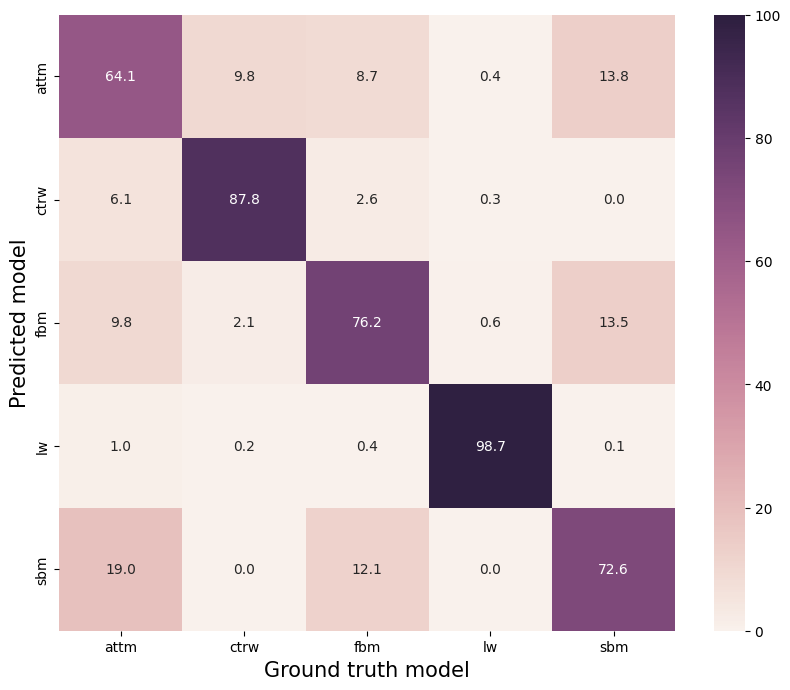

In [18]:
rnn = dl.RNN(n_features,hidden_features=[50],out_features=n_outputs,dropout=0.2,rnn_type="LSTM",bidirectional=True)
model = dl.Classifier(rnn, loss=torch.nn.CrossEntropyLoss(),optimizer=dl.Adam(lr=0.01))
model=model.create()
print(model)

y_test,predicted_y=train_and_predict(model)
computed_accuracy = accuracy(predicted_y, y_test)
print ("Accuracy:" , computed_accuracy)
confusion_matrix(predicted_y,y_test)

## Adding layers to LSTM (overfitting)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\ccx55\Anaconda3\envs\DLCC\Lib\site-packages\lightning\pytorch\utilities\model_summary\model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | Sequential       | 58.3 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
58.3 K    Trainable params
0         Non-trainable params
58.3 K    Total params
0.233     Total estimated model params size (MB)


Classifier(
  (loss): CrossEntropyLoss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): Sequential(
    (0): RecurrentNeuralNetwork(
      (blocks): LayerList(
        (0): LayerActivationNormalizationDropout(
          (layer): LSTM(4, 100)
          (activation): Identity()
          (normalization): Identity()
          (dropout): Drop()
        )
        (1): LayerActivationNormalizationDropout(
          (layer): LSTM(100, 30)
          (activation): Identity()
          (normalization): Identity()
          (dropout): Drop()
        )
      )
    )
    (1): MultiLayerPerceptron(
      (blocks): LayerList(
        (0): LayerActivationNormalizationDropout(
          (layer): LazyLinear(in_features=0, out_features=15, bias=True)
          (activation): ReLU()
          (normalization): Identity()
          (dropout): Dropout(p=0.2, inplace=False)
      

c:\Users\ccx55\Anaconda3\envs\DLCC\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\ccx55\Anaconda3\envs\DLCC\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 29: 100%|██████████| 201/201 [00:05<00:00, 38.17it/s, v_num=65, train_loss_step=1.940, val_loss_step=0.499, val_loss_epoch=0.493, train_loss_epoch=0.528]  

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 201/201 [00:05<00:00, 37.98it/s, v_num=65, train_loss_step=1.940, val_loss_step=0.499, val_loss_epoch=0.493, train_loss_epoch=0.528]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\ccx55\Anaconda3\envs\DLCC\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 63/63 [00:00<00:00, 129.71it/s]
Accuracy: tensor(0.7782)


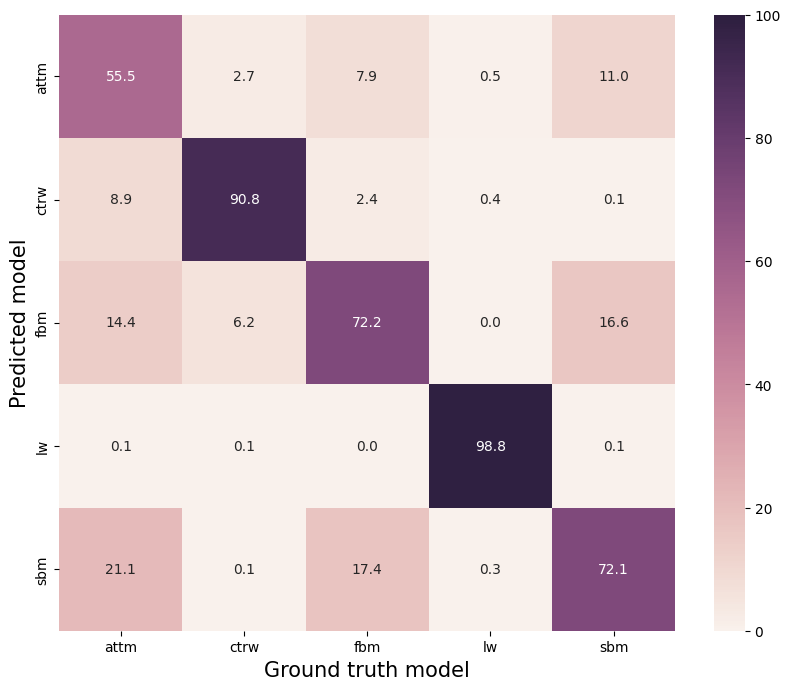

In [19]:
rnn = dl.RecurrentNeuralNetwork(n_features,hidden_features=[100],out_features=30)
rnn.blocks.layer.configure(torch.nn.LSTM)
rnn.blocks.dropout.configure(p=0.2)

dense_top=dl.MultiLayerPerceptron(in_features=None,hidden_features=[15],out_features=n_outputs)
dense_top.blocks.dropout.configure(p=0.2)

dense_rnn = dl.Sequential(rnn,dense_top)
model = dl.Classifier(dense_rnn, loss=torch.nn.CrossEntropyLoss(),optimizer=dl.Adam(lr=0.01))
model=model.create()
print(model)

y_test,predicted_y=train_and_predict(model)
computed_accuracy = accuracy(predicted_y, y_test)
print ("Accuracy:" , computed_accuracy)
confusion_matrix(predicted_y,y_test)